In [ ]:
import numpy as np
import math
from copy import deepcopy
import sklearn.datasets
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Dataset

We import the dataset from Hastie & Tibshirani book.
This is an artificially generated binary classification problem. Labels are in the set $\{-1,+1\}$.

In [ ]:
X,y = sklearn.datasets.make_hastie_10_2()
X_train = X[0:8000,:]
y_train = y[0:8000]
X_test = X[8000:,:]
y_test = y[8000:]

len(y_test)

4000

# Adaboost implementation

Here we implement the Adaboost algorith. We shall assume that:
- that the problem is a binary classification problem with labels in $\{-1, +1\}$.
- that the weakModel can fit a weighted sample set by means of the call `weakModel.fit(X,y,sample_weight=w)` where `w` is a vector of length $n=|X|=|y|$.

In [ ]:
class AdaBoost:
    def __init__(self, weakModel, T): #weakModel è il vettore dei pesi di probabilità di ogni esempio
        self.T = T #T è il numero di iterazioni ovvero il nuemro di weak learner che vogliamo apprendere
        self.weakModel = weakModel #sarà i lvettore dei pesi degli esempi
        self.alphas = [] #è il vettore che conterrà i pesi alfa t per ogni modello
        self.classifiers = [] #conterrà i vari modelli che abbiamo appreso
        self.wl_errors = [] #vettore che conterrà gli errori commessi dai singoli weak learner
        self.ens_errors = [] #vettore che conterrà gli errori fatti dal modello ensamble durante l'apprendimento

    def trainWeakModel(self, X, y, w):
        result = deepcopy(self.weakModel) #creo una copia di weakModel che è indipendente però da quella presente in self.weakModel
        result.fit(X,y, sample_weight=w)
        return result


    def weightedError(self, y, y_predette, w):
        return np.sum(w[y != y_predette])

        '''
        et = 0
        for i in range(len(y)):
          if(y[i] != y_predette[i]):
            et = et + w[i]
        return et
        '''

    def fit(self, X, y):

        n = len(y) #n è la dimensione del dataset
        w = np.ones(n) / n #setto il vettore dei pesi degli esempi a valori tutti equiprobabili (poichè all'inizio gli esempi hanno la stessa probabilità)

        ensamble_predictions = np.zeros(n)
        print_step = np.max([1, self.T/100])


        for t in range(self.T):

          mt = self.trainWeakModel(X,y,w)
          y_predette = mt.predict(X)
          et = self.weightedError(y, y_predette, w)

          if et >= 0.5:
            print("Errore il weak learner ha raggiunto un errore maggiore di 0.5!")

          at = 0.5 * math.log((1-et)/et)

          self.classifiers.append(mt)
          self.alphas.append(at)

          w = w * np.exp(-at * y * y_predette) #aggiorno il vettore dei pesi degli esempi

          #NORMALIZZO Il vettore w per fa si che la somma di tutti i suoi elementi sia 1:
          w = w / np.sum(w) #Al denominatore ho la somma di tutti i valori di w (ogni wi è maggiore di 0 quindi basta mettere la somma al denominatore)

          ensamble_predictions += at * y_predette
          ensamble_error = np.sum( np.sign(ensamble_predictions) != y ) / n #conto tutti gli esempi sbagliati dall'ensamble / numero totale di esempi (cosi' ottengo l'errore
          #totale commesso dall'ensamble)

          self.wl_errors.append(et)
          self.ens_errors.append(ensamble_error)

          if t > 1 and t % print_step==0: #stampo solo ogni tot di passi altrimenti avrei troppe stampe che sono costose
              print("step:{} et:{:.4f} error:{:.4f}".format(t, et, ensamble_error))



        return self



    def predict(self, X):
        result = np.zeros(len(X))

        for t in range(self.T):
          y_predette = self.classifiers[t].predict(X)
          result += self.alphas[t] + y_predette

        return np.sign(result)






# Testing with an SVM

Let us now see how our iplementation of AdaBoost performs on the dataset we loaded above. In this experiment we want the weak learning algorithm $\mathcal{A}$ to be good, but not too much. An SVM with a polynomial kernel of degre 3 works fine for our needs.

The SVC implementation provided by sklearn does not work well when weights are normalized. The following code simply "denormalize" weights befor calling into SVC implementation.

In [ ]:
    class SVC_:
        def __init__(self, kernel="rbf", degree="3"):
            self.svc = SVC(kernel=kernel, degree=degree)

        def fit(self, X,y,sample_weight=None):
            if sample_weight is not None:
                sample_weight = sample_weight * len(X) #scalo i pesi altrimenti la SVC di scikit non li accetta

            self.svc.fit(X,y,sample_weight=sample_weight)
            return self

        def predict(self, X):
            return self.svc.predict(X) #qui chiamo la predict della svm di scikit learn tanto non mi serve usare i pesi degli esempi

In [ ]:
weakModel = SVC_(kernel="poly", degree=3)
adaboost = AdaBoost(weakModel, 30) #eseguo adaboost usando come weak learner la SVM con un kernel polinomiale di grado 3
adaboost.fit(X_train, y_train)



step:2 et:0.3790 error:0.2734
step:3 et:0.4174 error:0.2734
step:4 et:0.3727 error:0.2249
step:5 et:0.4248 error:0.2249
step:6 et:0.3739 error:0.2900
step:7 et:0.4263 error:0.2072
step:8 et:0.3753 error:0.2477
step:9 et:0.4330 error:0.2360
step:10 et:0.3901 error:0.2109
step:11 et:0.4475 error:0.2109
step:12 et:0.3856 error:0.1919
step:13 et:0.4374 error:0.1919
step:14 et:0.3967 error:0.1951
step:15 et:0.4488 error:0.1884
step:16 et:0.4004 error:0.1950
step:17 et:0.4505 error:0.1879
step:18 et:0.4074 error:0.1845
step:19 et:0.4552 error:0.1821
step:20 et:0.4033 error:0.1760
step:21 et:0.4543 error:0.1739
step:22 et:0.4048 error:0.1779
step:23 et:0.4567 error:0.1714
step:24 et:0.4260 error:0.1721
step:25 et:0.4684 error:0.1695
step:26 et:0.4199 error:0.1686
step:27 et:0.4617 error:0.1679
step:28 et:0.4275 error:0.1664
step:29 et:0.4709 error:0.1648


train error:0.5005 test error:0.5035


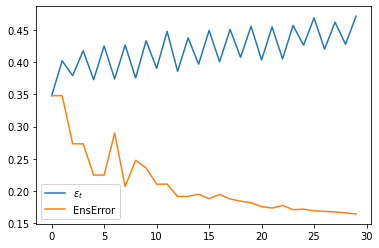

In [ ]:
#accuracy = (0.5 - y_train_.T * y_train/(2 * len(y_train)))

y_train_ = adaboost.predict(X_train)
y_test_ = adaboost.predict(X_test)


train_err = np.sum(y_train_ != y_train) / len(y_train)
test_err = np.sum(y_test_ != y_test) / len(y_test)

print("train error:{:.4f} test error:{:.4f}".format(train_err, test_err))


plt.plot(adaboost.wl_errors, label="$\epsilon_t$")
plt.plot(adaboost.ens_errors, label="EnsError")
plt.legend()

# Testing on the weakest of the weak learners

We now want to experiment with a VERY weak learner. The weak learner works as follows:

- it creates a random linear model by generating the needed weight vector $\mathbf{w}$ at random; each weight shall be sampled from U(-1,1);
- it evaluates the weighted loss $\epsilon_t$ on the given dataset and flip the linear model if $\epsilon_t > 0.5$
- at prediction time it predicts +1 if $\mathbf{x} \cdot \mathbf{w} > 0$ it predicts -1 otherwise.

In [ ]:
class RandomLinearModel:
    def loss(self, y, y_, w):
        return np.sum(w[y != y_])


    def fit(self,X,y,sample_weight=None):
        self.w = (np.random.rand(X.shape[1]) - 0.5) * 2.0 #genero a caso il vettore dei pesi del modello lineare a caso
        y_ = self.predict(X)

        if self.loss(y, y_, sample_weight) > 0.5:
            self.w = -self.w #ribalto il valore dei pesi in modo tale che per gli esempi dove prima prediceva 1 adesso predice -1 e viceversa

        return self


    def predict(self,X):
        return np.sign(np.matmul(X, self.w))





Let us now learn an AdaBoost model using the RandomLinearModel weak learner printing every $K$ iterations the weighted error and the current error of the ensemble. Evaluate the training and test error of the final ensemble model.

In [ ]:
rs = RandomLinearModel()
a = AdaBoost(rs,30000)
a.fit(X_train,y_train)

y_train_ = a.predict(X_train)
y_test_ = a.predict(X_test)

step:300 et:0.4972 error:0.4400
step:600 et:0.4949 error:0.4230
step:900 et:0.4997 error:0.3936
step:1200 et:0.4997 error:0.3842
step:1500 et:0.4972 error:0.3711
step:1800 et:0.4978 error:0.3608
step:2100 et:0.4943 error:0.3490
step:2400 et:0.4967 error:0.3448
step:2700 et:0.4989 error:0.3335
step:3000 et:0.4998 error:0.3262
step:3300 et:0.4991 error:0.3211
step:3600 et:0.4966 error:0.3110
step:3900 et:0.4955 error:0.3043
step:4200 et:0.4972 error:0.2994
step:4500 et:0.4972 error:0.2909
step:4800 et:0.4984 error:0.2839
step:5100 et:0.4953 error:0.2796
step:5400 et:0.4934 error:0.2760
step:5700 et:0.4963 error:0.2670
step:6000 et:0.5000 error:0.2570
step:6300 et:0.4970 error:0.2539
step:6600 et:0.4988 error:0.2464
step:6900 et:0.4983 error:0.2397
step:7200 et:0.4960 error:0.2400
step:7500 et:0.4998 error:0.2345
step:7800 et:0.4991 error:0.2290
step:8100 et:0.4957 error:0.2263
step:8400 et:0.4996 error:0.2213
step:8700 et:0.4975 error:0.2132
step:9000 et:0.4983 error:0.2107
step:9300 et:

train error:0.3816 test error:0.4980


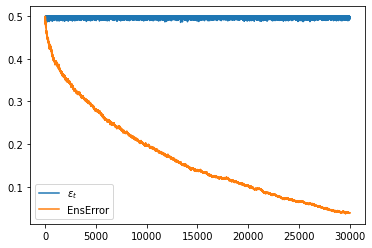

In [ ]:
plt.plot(a.wl_errors, label="$\epsilon_t$")
plt.plot(a.ens_errors, label="EnsError")
plt.legend()

train_err = np.sum(y_train_ != y_train) / len(y_train)
test_err = np.sum(y_test_ != y_test) / len(y_test)

print("train error:{:.4f} test error:{:.4f}".format(train_err, test_err))